

```
# This is formatted as code
```

# Assignment 2:  Implicit Neural Representation

Name: **Rishikesh Avinash Jadhav**

UID:  **119256534**

Link to Google Drive : **https://colab.research.google.com/drive/1xOUm91Hl-P5P7v4XIbEdbuI2ug7yf8jL?usp=sharing**

Please submit a PDF containing all outputs to gradescope by **October 31, 11:59pm**

----------------------------

In this assignment, you will get some hands-on experience with implicit neural representation (INR). With INR, we parameterize some signal (in our case images) with a neural network (in this assignment, we will use a basic feed-forward network). While in practice this might be useful for outpainting, super-resolution, and compression, in this assignment we will mainly focus on the basics, with some proof-of-concept outpainting at the end. Your outputs might not look great, this is okay as long as they are at least as good as the examples.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

As always, we start with the data. In this section, you will need to complete the following steps:

1. Choose an image. If you're working in colab, you will need to either mount your Google Drive, or else upload the file directly.
2. Write SingleImageDataset. This is how you'll convert your image into model inputs and targets. You will instantiate the dataset and a dataloader to check and make sure you did this part correctly.

### Question 1: Selecting an image (5 points)

Free points! Just show your image here. One catch- make sure the image is less than 62500 pixels, total. We do not want you to waste time waiting for your model to train.

In [2]:
from PIL import Image

# Set the path to the directory containing your image
image_path = "/content/drive/MyDrive/CMSC828I_HW2/"

image = Image.open(image_path + "redbull.jpg")

# Define maximum allowed pixel count(Given)
max_pixel_count = 62500

# Get current pixel count of the image
current_pixel_count = image.width * image.height

if current_pixel_count > max_pixel_count:
    # Calculate new dimensions to meet the maximum pixel count if no tin specified range
    new_width = int((max_pixel_count / current_pixel_count) ** 0.5 * image.width)
    new_height = int((max_pixel_count / current_pixel_count) ** 0.5 * image.height)

    # Resize the image to the new dimensions
    resized_image = image.resize((new_width, new_height))

    # Save resized image
    resized_image.save(image_path + "resized_redbull.jpg")

    print("Redbull is resized and saved.")
else:
    print("Image already meets the resolution requirement.")



Redbull is resized and saved.


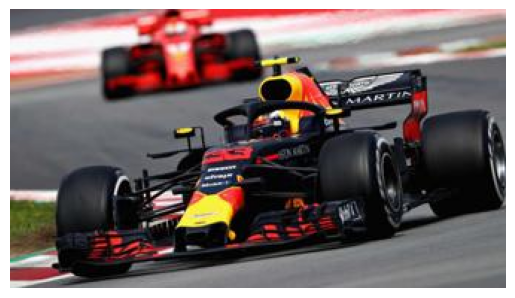

Total Pixels: 62271
Image Shape: torch.Size([3, 187, 333])


In [3]:
from torchvision.io import read_image  ## Note: feel free to use another loader
import matplotlib.pyplot as plt

# Load resized image
image = read_image(image_path + "resized_redbull.jpg")

# Display resized image
plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()
plt.close()

# Check total number of pixels in the image
total_pixels = image.shape[1] * image.shape[2]

# Print the total pixel count and image shape
print("Total Pixels:", total_pixels)
print("Image Shape:", image.shape)


### Question 2: Writing the dataset (20 points)

For this part, you need to fill in the blanks for the dataset provided below. Alternatively, feel free to write it from scratch, the scaffolding was provided to help you, not to trap you in a box.

You will also need to write a loop to construct the image, using a dataloader for your SingleImageDataset. We provide more details in comments below.

We will be grading your code and your image outputs. In Gradescope, make sure both are fully visible.

In [4]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class SingleImageDataset(Dataset):
    def __init__(self, img_path):
        self.image = read_image(img_path)
        self.num_channels, self.h, self.w = self.image.shape

    def __len__(self):
        ### TODO: 1 line of code for returning the number of pixels
        return self.h * self.w # Returning total number of pixels in the image

    def __getitem__(self, idx):
        ### TODO: 2-3 lines of code for x, y, and pixel values

        # Calculate the row and column based on the given index (idx)
        x = idx % self.w # column
        y = idx // self.w # row

        # Get pixel intensity value at (x, y)
        intensity = self.image[:, y, x]

        # Return a dictionary containing x, y, and pixel intensity
        return {"x": x, "y": y, "intensity": intensity}

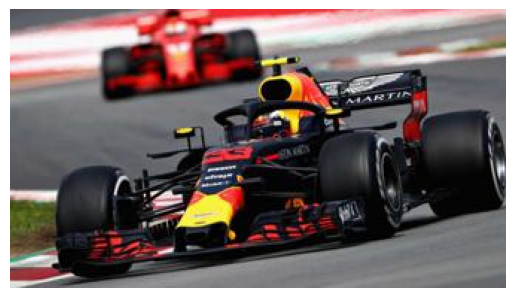

Displayed image shape : torch.Size([3, 187, 333])


In [5]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Creating a dataset from the resized image
dataset = SingleImageDataset(image_path + "resized_redbull.jpg")

### TODO: 1 line of code for initializing a DataLoader

# Initializing DataLoader to batch and shuffle the data
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### TODO: 6-10 lines of code for using your dataloader to retrieve, reassemble,
###       and display your image

# Initializing empty tensor to assemble the image
some_image = torch.zeros((dataset.num_channels, dataset.h, dataset.w), dtype=torch.float32)

# Iterating through the DataLoader to retrieve and reassemble the image
for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]

    # Iterating through the batch to assign values to individual pixels
    for i in range(batch["x"].shape[0]):
        some_image[:, y[i], x[i]] = intensity[i]

# Normalizing the pixel intensity values to [0.0, 1.0]
some_image_normalized = some_image / 255.0

# Display the reassembled image
plt.imshow(some_image_normalized.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

print("Displayed image shape :", some_image_normalized.shape)

## Network


### Question 3: Defining the Network (15 points)

Define a feedforward neural network.
Remember that the last layer output dimension should be equal to the number of color channels.

A very basic network might have a linear layer, followed by a ReLU, followed by another linear layer.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
import torch.nn as nn

class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        ### TODO: define and initialize some layers with weights
        self.layers = nn.Sequential(
            nn.Linear(2, 4096),  # Input layer with 2 input features and 4096 output features
            nn.ReLU(),          # ReLU activation function
            nn.Linear(4096, 1024),  # Hidden layer with 1024 output features
            nn.ReLU(),          # ReLU activation function
            nn.Linear(1024, 512),  # Another hidden layer with 512 output features
            nn.ReLU(),          # ReLU activation function
            nn.Linear(512, 3)    # Output layer with 3 output features
        )

    def forward(self, coord):
        # Forward pass through the defined layers
        return self.layers(coord)


## Training

Now that you have a dataset and model, time to put it together!

Instantiate an optimizer and a criterion.
Loop over your dataset until the network converges.
Track your loss. We will be asking you to plot it later.

In [8]:
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler


# Setting the seed for PyTorch
torch.manual_seed(42)

net = FFN()

# Since we are training the network for pixels, we will do a pixelwise MSE loss
loss_function = torch.nn.MSELoss()
learning_rate=0.01
NUM_EPOCHS = 100  # Set the desired number of epochs

def train_model(model, dataloader, num_epochs,loss_function, learning_rate=learning_rate, device='cpu'):
    """
    Train a model using the specified parameters.

    Args:
        model (torch.nn.Module): The model to train.
        dataloader (DataLoader): The DataLoader containing the training data.
        num_epochs (int): The number of training epochs.
        loss_function: The loss function to optimize.
        learning_rate (float): The learning rate for the optimizer.
        device (str): The device to use for training ('cuda' or 'cpu').

    Returns:
        list: A list of loss values for each epoch.
    """

    # Moving the model to the specified device
    model.to(device)

    # Since we are training the network for pixels, we will do a pixelwise MSE loss
    loss_function = torch.nn.MSELoss()

    # Setting up the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Creating lists to store loss values
    loss_values = []

    # Setting up the learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    for epoch in range(num_epochs):
        epoch_loss = 0.0  # Initializing loss for the current epoch
        model.train()  # Setting the model in training mode

        for batch in tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            # Retrieving batch data
            x, y, actual = batch["x"], batch["y"], batch["intensity"]

            # Normalizing coordinates
            x = x / dataset.w  # Normalize x between 0 and 1
            y = y / dataset.h  # Normalize y between 0 and 1

            # Moving data to the specified device
            x, y, actual = x.to(device).float(), y.to(device).float(), actual.to(device).float()

            # Assembling coordinates
            coord = torch.stack((x, y), dim=1)

            # Forward pass
            pred = model(coord)

            # Computing loss
            loss = loss_function(pred, actual)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Adjust learning rate using the scheduler
        scheduler.step()

        # Store the average loss for the epoch in loss_values
        loss_values.append(epoch_loss / len(dataloader))

        # Print progress with loss for the current epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(dataloader)}")

    print('Training finished.')
    # Return the list of loss values
    return loss_values

# Replace 'device' with 'cuda' for GPU training or 'cpu' for CPU training
losses = train_model(net, dataloader, NUM_EPOCHS, loss_function, learning_rate, device='cuda')

Epoch 1/100: 100%|██████████| 973/973 [00:07<00:00, 132.90it/s]


Epoch [1/100], Loss: 2512.109348402974


Epoch 2/100: 100%|██████████| 973/973 [00:03<00:00, 246.50it/s]


Epoch [2/100], Loss: 1878.7304097848953


Epoch 3/100: 100%|██████████| 973/973 [00:03<00:00, 255.98it/s]


Epoch [3/100], Loss: 1725.7256548137607


Epoch 4/100: 100%|██████████| 973/973 [00:06<00:00, 155.14it/s]


Epoch [4/100], Loss: 1561.05032634049


Epoch 5/100: 100%|██████████| 973/973 [00:03<00:00, 252.43it/s]


Epoch [5/100], Loss: 1434.464096963222


Epoch 6/100: 100%|██████████| 973/973 [00:03<00:00, 251.98it/s]


Epoch [6/100], Loss: 1363.4370869306229


Epoch 7/100: 100%|██████████| 973/973 [00:04<00:00, 214.96it/s]


Epoch [7/100], Loss: 1312.0591051154613


Epoch 8/100: 100%|██████████| 973/973 [00:03<00:00, 254.79it/s]


Epoch [8/100], Loss: 1273.7392816494573


Epoch 9/100: 100%|██████████| 973/973 [00:03<00:00, 256.22it/s]


Epoch [9/100], Loss: 1213.2556226677418


Epoch 10/100: 100%|██████████| 973/973 [00:04<00:00, 226.69it/s]


Epoch [10/100], Loss: 1156.8082157460415


Epoch 11/100: 100%|██████████| 973/973 [00:03<00:00, 243.38it/s]


Epoch [11/100], Loss: 1108.7193634880043


Epoch 12/100: 100%|██████████| 973/973 [00:03<00:00, 257.63it/s]


Epoch [12/100], Loss: 1078.2674150927585


Epoch 13/100: 100%|██████████| 973/973 [00:03<00:00, 250.76it/s]


Epoch [13/100], Loss: 1075.871366526338


Epoch 14/100: 100%|██████████| 973/973 [00:04<00:00, 219.42it/s]


Epoch [14/100], Loss: 1033.4754438566893


Epoch 15/100: 100%|██████████| 973/973 [00:03<00:00, 257.20it/s]


Epoch [15/100], Loss: 1024.9640320702422


Epoch 16/100: 100%|██████████| 973/973 [00:03<00:00, 253.33it/s]


Epoch [16/100], Loss: 970.8530157075511


Epoch 17/100: 100%|██████████| 973/973 [00:04<00:00, 219.30it/s]


Epoch [17/100], Loss: 967.7133989167482


Epoch 18/100: 100%|██████████| 973/973 [00:03<00:00, 249.47it/s]


Epoch [18/100], Loss: 956.0209629101964


Epoch 19/100: 100%|██████████| 973/973 [00:03<00:00, 255.78it/s]


Epoch [19/100], Loss: 940.022984535084


Epoch 20/100: 100%|██████████| 973/973 [00:04<00:00, 239.17it/s]


Epoch [20/100], Loss: 915.2866865826535


Epoch 21/100: 100%|██████████| 973/973 [00:04<00:00, 228.74it/s]


Epoch [21/100], Loss: 737.6961371646265


Epoch 22/100: 100%|██████████| 973/973 [00:03<00:00, 251.79it/s]


Epoch [22/100], Loss: 728.381465476684


Epoch 23/100: 100%|██████████| 973/973 [00:03<00:00, 252.75it/s]


Epoch [23/100], Loss: 708.5124192428981


Epoch 24/100: 100%|██████████| 973/973 [00:04<00:00, 212.15it/s]


Epoch [24/100], Loss: 700.7570208307405


Epoch 25/100: 100%|██████████| 973/973 [00:03<00:00, 255.42it/s]


Epoch [25/100], Loss: 686.9524934460914


Epoch 26/100: 100%|██████████| 973/973 [00:03<00:00, 256.73it/s]


Epoch [26/100], Loss: 687.8386711442091


Epoch 27/100: 100%|██████████| 973/973 [00:04<00:00, 228.39it/s]


Epoch [27/100], Loss: 683.3993412186406


Epoch 28/100: 100%|██████████| 973/973 [00:04<00:00, 233.12it/s]


Epoch [28/100], Loss: 675.6806113702788


Epoch 29/100: 100%|██████████| 973/973 [00:03<00:00, 253.79it/s]


Epoch [29/100], Loss: 662.2252395959209


Epoch 30/100: 100%|██████████| 973/973 [00:03<00:00, 250.04it/s]


Epoch [30/100], Loss: 655.8343511191326


Epoch 31/100: 100%|██████████| 973/973 [00:04<00:00, 218.52it/s]


Epoch [31/100], Loss: 654.8614905299532


Epoch 32/100: 100%|██████████| 973/973 [00:03<00:00, 256.48it/s]


Epoch [32/100], Loss: 646.7154571125466


Epoch 33/100: 100%|██████████| 973/973 [00:03<00:00, 256.48it/s]


Epoch [33/100], Loss: 651.7080558471052


Epoch 34/100: 100%|██████████| 973/973 [00:04<00:00, 223.25it/s]


Epoch [34/100], Loss: 644.7356651909918


Epoch 35/100: 100%|██████████| 973/973 [00:03<00:00, 247.05it/s]


Epoch [35/100], Loss: 636.118091547967


Epoch 36/100: 100%|██████████| 973/973 [00:03<00:00, 254.44it/s]


Epoch [36/100], Loss: 633.2615828636616


Epoch 37/100: 100%|██████████| 973/973 [00:04<00:00, 240.60it/s]


Epoch [37/100], Loss: 621.3418567339907


Epoch 38/100: 100%|██████████| 973/973 [00:04<00:00, 224.81it/s]


Epoch [38/100], Loss: 631.509704009602


Epoch 39/100: 100%|██████████| 973/973 [00:03<00:00, 252.93it/s]


Epoch [39/100], Loss: 636.8881881886372


Epoch 40/100: 100%|██████████| 973/973 [00:03<00:00, 251.61it/s]


Epoch [40/100], Loss: 618.3052977261049


Epoch 41/100: 100%|██████████| 973/973 [00:04<00:00, 213.44it/s]


Epoch [41/100], Loss: 527.7133487258394


Epoch 42/100: 100%|██████████| 973/973 [00:03<00:00, 256.44it/s]


Epoch [42/100], Loss: 520.0423953614034


Epoch 43/100: 100%|██████████| 973/973 [00:03<00:00, 255.48it/s]


Epoch [43/100], Loss: 522.4734691372878


Epoch 44/100: 100%|██████████| 973/973 [00:04<00:00, 238.68it/s]


Epoch [44/100], Loss: 518.5391400955687


Epoch 45/100: 100%|██████████| 973/973 [00:04<00:00, 231.23it/s]


Epoch [45/100], Loss: 509.5595807098044


Epoch 46/100: 100%|██████████| 973/973 [00:03<00:00, 254.27it/s]


Epoch [46/100], Loss: 510.62650732685336


Epoch 47/100: 100%|██████████| 973/973 [00:03<00:00, 255.18it/s]


Epoch [47/100], Loss: 509.71979478010786


Epoch 48/100: 100%|██████████| 973/973 [00:04<00:00, 216.47it/s]


Epoch [48/100], Loss: 503.9998461888971


Epoch 49/100: 100%|██████████| 973/973 [00:03<00:00, 254.83it/s]


Epoch [49/100], Loss: 502.63161227783957


Epoch 50/100: 100%|██████████| 973/973 [00:03<00:00, 258.46it/s]


Epoch [50/100], Loss: 501.3124857605545


Epoch 51/100: 100%|██████████| 973/973 [00:04<00:00, 229.27it/s]


Epoch [51/100], Loss: 498.71344135280503


Epoch 52/100: 100%|██████████| 973/973 [00:04<00:00, 238.48it/s]


Epoch [52/100], Loss: 496.88028278723283


Epoch 53/100: 100%|██████████| 973/973 [00:03<00:00, 254.60it/s]


Epoch [53/100], Loss: 497.94531315865277


Epoch 54/100: 100%|██████████| 973/973 [00:03<00:00, 251.36it/s]


Epoch [54/100], Loss: 496.15714360361596


Epoch 55/100: 100%|██████████| 973/973 [00:04<00:00, 223.55it/s]


Epoch [55/100], Loss: 487.92514351730114


Epoch 56/100: 100%|██████████| 973/973 [00:03<00:00, 258.38it/s]


Epoch [56/100], Loss: 489.0726486472652


Epoch 57/100: 100%|██████████| 973/973 [00:03<00:00, 255.25it/s]


Epoch [57/100], Loss: 486.128599741231


Epoch 58/100: 100%|██████████| 973/973 [00:04<00:00, 223.24it/s]


Epoch [58/100], Loss: 488.0538660423851


Epoch 59/100: 100%|██████████| 973/973 [00:03<00:00, 244.08it/s]


Epoch [59/100], Loss: 486.94723001070406


Epoch 60/100: 100%|██████████| 973/973 [00:03<00:00, 253.83it/s]


Epoch [60/100], Loss: 486.796425720403


Epoch 61/100: 100%|██████████| 973/973 [00:04<00:00, 240.24it/s]


Epoch [61/100], Loss: 435.1138382036419


Epoch 62/100: 100%|██████████| 973/973 [00:04<00:00, 221.53it/s]


Epoch [62/100], Loss: 432.70853067302016


Epoch 63/100: 100%|██████████| 973/973 [00:03<00:00, 252.93it/s]


Epoch [63/100], Loss: 434.43644135681967


Epoch 64/100: 100%|██████████| 973/973 [00:03<00:00, 251.35it/s]


Epoch [64/100], Loss: 432.1504016025461


Epoch 65/100: 100%|██████████| 973/973 [00:04<00:00, 213.05it/s]


Epoch [65/100], Loss: 435.28764830194297


Epoch 66/100: 100%|██████████| 973/973 [00:03<00:00, 256.67it/s]


Epoch [66/100], Loss: 428.6368143173798


Epoch 67/100: 100%|██████████| 973/973 [00:03<00:00, 254.43it/s]


Epoch [67/100], Loss: 428.69428510362053


Epoch 68/100: 100%|██████████| 973/973 [00:04<00:00, 233.10it/s]


Epoch [68/100], Loss: 425.32080896736295


Epoch 69/100: 100%|██████████| 973/973 [00:04<00:00, 233.71it/s]


Epoch [69/100], Loss: 427.1849124198827


Epoch 70/100: 100%|██████████| 973/973 [00:03<00:00, 257.11it/s]


Epoch [70/100], Loss: 424.54852084780276


Epoch 71/100: 100%|██████████| 973/973 [00:03<00:00, 256.41it/s]


Epoch [71/100], Loss: 421.8256934813826


Epoch 72/100: 100%|██████████| 973/973 [00:04<00:00, 219.14it/s]


Epoch [72/100], Loss: 421.41535183631134


Epoch 73/100: 100%|██████████| 973/973 [00:03<00:00, 258.41it/s]


Epoch [73/100], Loss: 421.64598967972665


Epoch 74/100: 100%|██████████| 973/973 [00:03<00:00, 257.07it/s]


Epoch [74/100], Loss: 419.56127970461245


Epoch 75/100: 100%|██████████| 973/973 [00:04<00:00, 227.68it/s]


Epoch [75/100], Loss: 419.0329323010969


Epoch 76/100: 100%|██████████| 973/973 [00:04<00:00, 238.90it/s]


Epoch [76/100], Loss: 415.87026638019245


Epoch 77/100: 100%|██████████| 973/973 [00:03<00:00, 256.06it/s]


Epoch [77/100], Loss: 418.5574153966796


Epoch 78/100: 100%|██████████| 973/973 [00:03<00:00, 246.12it/s]


Epoch [78/100], Loss: 415.81558869725507


Epoch 79/100: 100%|██████████| 973/973 [00:04<00:00, 222.20it/s]


Epoch [79/100], Loss: 415.6000257062765


Epoch 80/100: 100%|██████████| 973/973 [00:03<00:00, 252.89it/s]


Epoch [80/100], Loss: 413.7805000454157


Epoch 81/100: 100%|██████████| 973/973 [00:03<00:00, 259.95it/s]


Epoch [81/100], Loss: 391.1865370026105


Epoch 82/100: 100%|██████████| 973/973 [00:04<00:00, 222.61it/s]


Epoch [82/100], Loss: 391.26415107625115


Epoch 83/100: 100%|██████████| 973/973 [00:03<00:00, 248.75it/s]


Epoch [83/100], Loss: 391.3150735994282


Epoch 84/100: 100%|██████████| 973/973 [00:03<00:00, 257.32it/s]


Epoch [84/100], Loss: 389.90300270856835


Epoch 85/100: 100%|██████████| 973/973 [00:03<00:00, 247.45it/s]


Epoch [85/100], Loss: 388.3778981192139


Epoch 86/100: 100%|██████████| 973/973 [00:04<00:00, 226.89it/s]


Epoch [86/100], Loss: 388.6488204595364


Epoch 87/100: 100%|██████████| 973/973 [00:03<00:00, 258.92it/s]


Epoch [87/100], Loss: 388.2111588151702


Epoch 88/100: 100%|██████████| 973/973 [00:03<00:00, 260.51it/s]


Epoch [88/100], Loss: 386.4133539307644


Epoch 89/100: 100%|██████████| 973/973 [00:04<00:00, 221.90it/s]


Epoch [89/100], Loss: 387.57439406141106


Epoch 90/100: 100%|██████████| 973/973 [00:03<00:00, 255.71it/s]


Epoch [90/100], Loss: 386.09231442709256


Epoch 91/100: 100%|██████████| 973/973 [00:03<00:00, 259.78it/s]


Epoch [91/100], Loss: 386.0098020312475


Epoch 92/100: 100%|██████████| 973/973 [00:04<00:00, 237.54it/s]


Epoch [92/100], Loss: 385.37747829080485


Epoch 93/100: 100%|██████████| 973/973 [00:04<00:00, 228.50it/s]


Epoch [93/100], Loss: 384.64511262868194


Epoch 94/100: 100%|██████████| 973/973 [00:03<00:00, 252.99it/s]


Epoch [94/100], Loss: 384.06129486930826


Epoch 95/100: 100%|██████████| 973/973 [00:03<00:00, 254.91it/s]


Epoch [95/100], Loss: 384.5517694800633


Epoch 96/100: 100%|██████████| 973/973 [00:04<00:00, 214.54it/s]


Epoch [96/100], Loss: 384.0564989127211


Epoch 97/100: 100%|██████████| 973/973 [00:03<00:00, 256.57it/s]


Epoch [97/100], Loss: 382.4928890671294


Epoch 98/100: 100%|██████████| 973/973 [00:03<00:00, 258.61it/s]


Epoch [98/100], Loss: 380.91755571198735


Epoch 99/100: 100%|██████████| 973/973 [00:04<00:00, 232.84it/s]


Epoch [99/100], Loss: 381.0844962422919


Epoch 100/100: 100%|██████████| 973/973 [00:04<00:00, 236.98it/s]

Epoch [100/100], Loss: 380.1707000889244
Training finished.


### Question 4: Plot loss over time (20 points)

For this part, plot your loss from training the model.

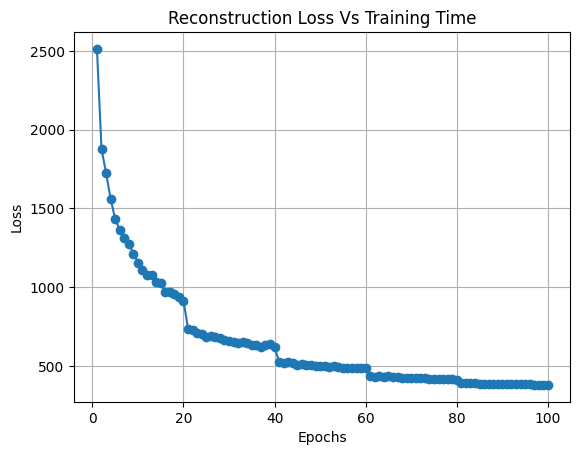

In [9]:
### TODO: make plot of reconstruction loss (y-axis) over training time (x-axis)
import matplotlib.pyplot as plt

# Plot the loss over time
plt.plot(range(1, NUM_EPOCHS + 1), losses, marker='o')
plt.title('Reconstruction Loss Vs Training Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## Evaluation

### Question 5: Reconstruct whole image (20 points)

For this part, reconstruct the image using your model's outputs, at each coordinate.
You can use our scaffolding code, or write your own.
For this part, we are just grading the image plot, where you should plot the original image side-by-side with the reconstruction, as shown in this example.

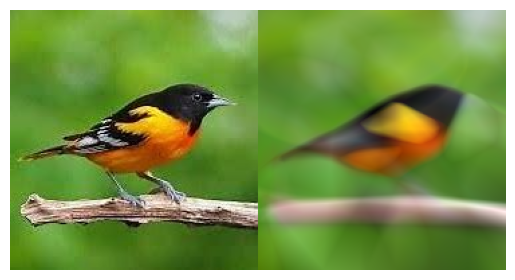

100%|██████████| 333/333 [00:24<00:00, 13.45it/s]


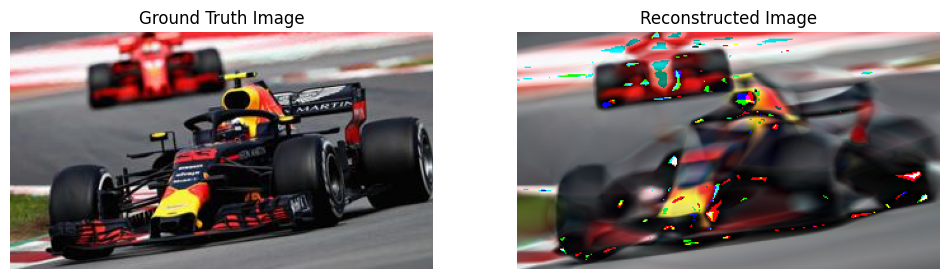

In [20]:
### TODO: ~12 lines of code to assemble gt_image, build pred_image
###       from model
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Loading the ground truth image from the dataset
gt_image = read_image(image_path + "resized_redbull.jpg")

# Seting up the pred_image as an empty tensor with the same shape as gt_image
pred_image = torch.zeros_like(gt_image)

# Iterate through each coordinate (x, y) to predict the pixel values
for x in tqdm(range(gt_image.shape[2])):
    for y in range(gt_image.shape[1]):
        # Normalizing x and y values between 0 and 1
        normalized_x = x / gt_image.shape[2]
        normalized_y = y / gt_image.shape[1]

        # Assembling coord from normalized x and y
        coord = torch.tensor([normalized_x, normalized_y])
        coord = coord.to(device)

        # Using model to predict the pixel value at this coordinate
        pred_intensity = net(coord)

        # Updating pred_image with the predicted intensity
        pred_image[:, y, x] = pred_intensity

# # Concatenate the ground truth image and predicted image horizontally
# joint_image = torch.cat([gt_image, pred_image], dim=2)

# Applying torch.clamp to ensure predicted values are within the valid range [0, 1]
pred_image = torch.clamp(pred_image, 0, 255)

# Creating a copy of the outpainted image for displaying
pred_display_image = pred_image.clone().detach().cpu().permute(1, 2, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ground truth image in first subplot
ax1.imshow(gt_image.permute(1, 2, 0).detach().numpy())
ax1.set_title("Ground Truth Image")
ax1.axis('off')

# Plot the predicted image in second subplot
ax2.imshow(pred_display_image.numpy())
plt.title("Reconstructed Image")
ax2.axis('off')

plt.show()
plt.close()


### Question 6: Compute PSNR (10 points)

For this part, print the PSNR for your reconstruction vs. the original image. Feel free to use any libraries, or implement it from scratch.

In [11]:
### TODO: compute and print PSNR between reconstructed (predicted) and ground truth images

#  Peak Signal-to-Noise Ratio (PSNR) between the reconstructed image and the original image
# FORMULA TO COMPUTE PSNR
# PSNR = 20 * log10(MAX) - 10 * log10(MSE)

import torch
import numpy as np

# Ensuring both images are in the correct format and range
gt_image = gt_image.float() / 255.0
pred_image = pred_image.float() / 255.0

# Calculatig the Mean Squared Error (MSE)
mse = torch.mean((gt_image - pred_image) ** 2)

# Converting the maximum pixel value (MAX) to a tensor
MAX = torch.tensor(255.0)

# Calculating the PSNR using the formula
psnr = 20 * torch.log10(MAX) - 10 * torch.log10(mse)

# Converting the PSNR to a numpy array
psnr = psnr.item()

print(f"PSNR: {psnr} dB")




PSNR: 65.75267791748047 dB


### Question 7: Outpainting (10 points)

INR is a continuous image representation. What happens if your input coordinates don't correspond to real pixels? Try it out and show the result!

For this part, have your model predict 20 pixels in all directions that are outside the boundaries of the original image, and show the resulting image below. Also plot a box around the region corresponding to the original image, for clarity.

We show an example below.

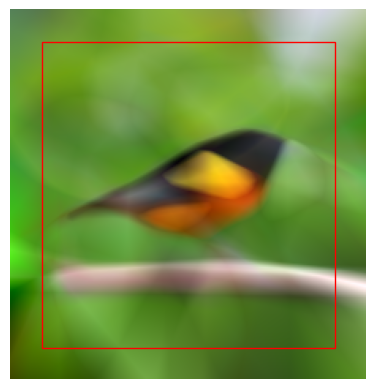

100%|██████████| 373/373 [00:39<00:00,  9.56it/s]


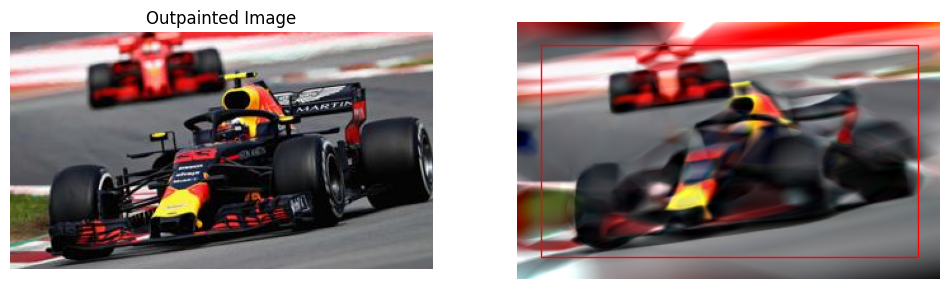

In [21]:
import matplotlib.patches as patches
from tqdm import tqdm

### TODO: 6-10 lines of code to generate outpainted image
import matplotlib.patches as patches

# Define the extended region for outpainting (20 pixels in all directions)
outpaint_width = dataset.w + 40  # Extend by 20 pixels to the left and 20 pixels to the right
outpaint_height = dataset.h + 40  # Extend by 20 pixels to the top and 20 pixels to the bottom

# Create an empty tensor for outpainting with the extended dimensions
outpainted_image = torch.zeros((3, outpaint_height, outpaint_width))

for x in tqdm(range(outpaint_width)):
    for y in range(outpaint_height):
      if x<333 or x>20 and y<187 or y>20:
        # Normalizing x and y values between 0 and 1 for the extended region
          normalized_x = (x-20) / 333
          normalized_y = (y-20) / 187

      # Assembling coord from normalized x and y
      coord = torch.tensor([normalized_x, normalized_y])
      coord = coord.to(device)

      # Using your model to predict the pixel value at this coordinate
      pred_intensity = net(coord)

      # Updating the outpainted image with the predicted intensity
      outpainted_image[:, y, x] = pred_intensity

# Creating a copy of the outpainted image for displaying
display_image = outpainted_image.clone().detach().cpu().permute(1, 2, 0)

display_image_normalized = display_image / 255.0

# Highlighting the region corresponding to the original image
rect = patches.Rectangle((20, 20), dataset.w, dataset.h, linewidth=1, edgecolor='r', facecolor='none')

# print("Display image normalized",display_image_normalized.shape)
# print("GT image shape",gt_image.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ground truth image in the first subplot
ax1.imshow(gt_image.permute(1, 2, 0).detach().numpy())
ax1.set_title("Ground Truth Image")
ax1.axis('off')

# Plot the ground truth image in the first subplot
ax2.imshow(display_image_normalized.numpy())
ax2.add_patch(rect)
ax1.set_title("Outpainted Image")
plt.axis('off')

plt.show()
plt.close()


## Bonus

The main idea of the bonus is to do something to make your model better than the one we walk you through in the assignment. Be creative! You can receive a maximum of 20 points for this portion.

### Question 8: Improve the Reconstruction Quality of the System (20 points, optional)

For this question, you must do two things:

1. Make a non-trivial change from what we guided you through in the assignment.
2. Prove that the change improves reconstruction quality. Compare your new output/PSNR to the old output/PSNR (plot the images, print the PSNR).

If you can't think of your own idea, revisit some of the literature from Shishira's guest lectures. For example, instead of taking raw coordinate inputs, you could try using positional encodings.